# YOLOv5 Sparse Transfer Learning Example

This tutorial shows how Neural Magic sparse models simplify the sparsification process by offering pre-sparsified YOLOv5 models for transfer learning onto other datasets.

For a detailed guide of all the capabilities, view the documentation for the pipeline: https://docs.neuralmagic.com/get-started/transfer-a-sparsified-model/cv-object-detection

## Install Dependencies


In [ ]:
!nvidia-smi

Tue Feb 28 18:37:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install sparseml[yolov5] wandb
!pip uninstall -y tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.8/904.8 KB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 KB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━

## [Optional] Connect to Weights & Biases account to monitor training

In [ ]:
!wandb login "53565a81995ab9c9d4469dc389b51e8060f99069"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Transfer Learning the Model

The sparse upstream model is YOLOv5s: https://sparsezoo.neuralmagic.com/models/yolov5-s-coco-pruned75_quantized?hardware=deepsparse-c6i.12xlarge&comparison=yolov5-s-coco-base

The training command will take less 20 minutes to complete on a T4. Afterward, you will have a sparse model transfer learned onto the COCO128 dataset.

You can try it on another dataset by changing the `--data VOC.yaml` argument.

The command uses the `--recipe` argument to encode the proper hyperparams such that SparseML will enforce the sparsity for all layers. Without the proper recipes, the zeroed weights will slowly become dense as the model is trained further. The recipes are specific to the sparsification type, so the training command will differ based on if you are transfer learning the pruned quantized, pruned, or baseline model.

In [ ]:
!sparseml.yolov5.train \
    --cfg yolov5s.yaml \
    --data coco128.yaml \
    --hyp hyps/hyp.finetune.yaml \
    --weights zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned75_quant-none?recipe_type=transfer_learn \
    --recipe zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned75_quant-none?recipe_type=transfer_learn \
    --project "coco128-yolov5"

2023-02-28 18:41:25 sparseml.yolov5 WARNING  sparseml-yolov5 installation not detected. Installing sparseml-yolov5 dependencies if yolov5 is already installed in the environment, it will be overwritten. Set environment variable NM_NO_AUTOINSTALL_YOLOV5 to disable
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 KB 612.3 kB/s eta 0:00:00
2023-02-28 18:41:33 sparseml.yolov5 INFO     sparseml-yolov5 and dependencies successfully installed
wandb: Currently logged in as: neuralmagic. Use `wandb login --relogin` to force relogin
train: weights=zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned75_quant-none?recipe_type=transfer_learn, cfg=yolov5s.yaml, teacher_weights=, data=coco128.yaml, data_path=, hyp=hyps/hyp.finetune.yaml, epochs=300, batch_size=16, gradient_accum_steps=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve

## Exporting for Inference

This step loads a checkpoint file of the best weights measured on the validation set, and converts it into the more common inference formats.

Now you can run the `.onnx` file through a compression algorithm to reduce its deployment size and run it in ONNX-compatible inference engines such as DeepSparse. The DeepSparse Engine is explicitly coded to support running sparsified models for significant improvements in inference performance. An example for benchmarking and deploying YOLOv5 models with DeepSparse can be found [here](https://github.com/neuralmagic/deepsparse/tree/main/src/deepsparse/yolo).


In [ ]:
!sparseml.yolov5.export_onnx \
    --weights /content/coco128-yolov5/exp/weights/last.pt \
    --dynamic

wandb: Currently logged in as: neuralmagic. Use `wandb login --relogin` to force relogin
export: data=../usr/local/lib/python3.8/dist-packages/yolov5/data/coco128.yaml, data_path=, weights=['/content/coco128-yolov5/exp/weights/last.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=True, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, export_samples=0, include=['onnx'], one_shot=None
export: data=../usr/local/lib/python3.8/dist-packages/yolov5/data/coco128.yaml, data_path=, weights=['/content/coco128-yolov5/exp/weights/last.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=True, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, export_

Now your final `.onnx` model is at `/content/coco128-yolov5/exp/weights/last.onnx` and ready for sparse inference with the DeepSparse Engine.

# Measure the difference in compression

In [ ]:
!ls -sh /content/coco128-yolov5/exp/weights/last.pt

15M /content/coco128-yolov5/exp/weights/last.pt


In [ ]:
!tar cfz yolov5s-pruned-quant.tar.gz /content/coco128-yolov5/exp/DeepSparse_Deployment/last.onnx
!ls -sh yolov5s-pruned-quant.tar.gz

tar: Removing leading `/' from member names
2.4M yolov5s-pruned-quant.tar.gz


Through pruning and quantization, we were able to take the file size of the model from 15MB to just 2.4MB, a **6x compression**!

# Use the sparsified model for inference with the DeepSparse Engine

In [ ]:
!pip install deepsparse[yolo]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 17.4 MB/s eta 0:00:00


In [ ]:
!wget -O basilica.jpg https://raw.githubusercontent.com/neuralmagic/deepsparse/main/src/deepsparse/yolo/sample_images/basilica.jpg

--2023-02-28 18:58:48--  https://raw.githubusercontent.com/neuralmagic/deepsparse/main/src/deepsparse/yolo/sample_images/basilica.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129644 (127K) [image/jpeg]
Saving to: ‘basilica.jpg’

basilica.jpg        100%[===================>] 126.61K  --.-KB/s    in 0.004s  

2023-02-28 18:58:48 (27.5 MB/s) - ‘basilica.jpg’ saved [129644/129644]



In [ ]:
!deepsparse.object_detection.annotate --model_filepath /content/coco128-yolov5/exp/DeepSparse_Deployment/last.onnx --source basilica.jpg

2023-02-28 18:59:00 deepsparse.utils.annotate INFO     Results will be saved to annotation-results/deepsparse-annotations
DeepSparse, Copyright 2021-present / Neuralmagic, Inc. version: 1.4.0 COMMUNITY | (3be6be5f) (release) (optimized) (system=avx512, binary=avx512)
[7f054de8c740 >WARN<  operator() ./src/include/wand/utility/warnings.hpp:14] Generating emulated code for quantized (INT8) operations since no VNNI instructions were detected. Set NM_FAST_VNNI_EMULATION=1 to increase performance at the expense of accuracy.
2023-02-28 18:59:14 deepsparse.yolo.annotate INFO     Results saved to annotation-results/deepsparse-annotations


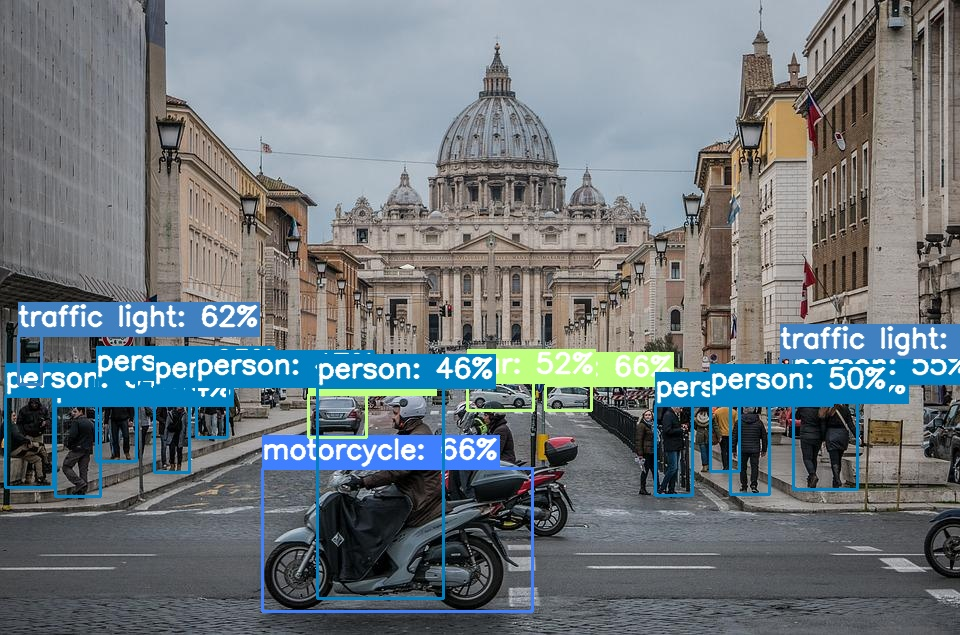

In [ ]:
from IPython.display import Image, display
display(Image("annotation-results/deepsparse-annotations/result-0.jpg"))

In [ ]:
from deepsparse import Pipeline

model_stub = "/content/coco128-yolov5/exp/DeepSparse_Deployment/last.onnx"
images = ["basilica.jpg"]

yolo_pipeline = Pipeline.create(
    task="yolo",
    model_path=model_stub,
)

pipeline_outputs = yolo_pipeline(images=images, iou_thres=0.6, conf_thres=0.001)
print(pipeline_outputs)

boxes=[[[486.8299560546875, 406.5753479003906, 513.85205078125, 498.5209045410156], [38.20564651489258, 412.2727355957031, 66.52555084228516, 501.0442199707031], [5.494261741638184, 398.1700439453125, 36.417694091796875, 488.057861328125], [174.00155639648438, 474.58538818359375, 355.5301818847656, 617.9143676757812], [64.6265640258789, 381.8066711425781, 91.57918548583984, 465.8198547363281], [12.750226974487305, 340.32708740234375, 28.392793655395508, 388.1719970703125], [361.8306884765625, 387.5428771972656, 395.33233642578125, 415.9248352050781], [528.5475463867188, 388.435791015625, 570.4208374023438, 494.2554931640625], [433.50091552734375, 405.62939453125, 461.39111328125, 501.50103759765625], [473.8440856933594, 401.9554443359375, 492.5108337402344, 475.17572021484375], [213.4166259765625, 392.11053466796875, 298.60101318359375, 604.3539428710938], [206.0814971923828, 394.9605407714844, 244.0352020263672, 441.5499572753906], [311.61602783203125, 386.0011291503906, 355.519409179

Now you can use the sparse model to deploy efficiently with DeepSparse - utilizing pipelines, model servers, and benchmarking flows to scale performance for any size CPU! Check out our guide here: https://docs.neuralmagic.com/get-started/use-a-model/cv-object-detection